# TRABAJO UT5 - REGRESIÓN
**Alumno:** Borja Ramos Oliva  
**curso:** Especialización en IA & Big Data 

Análisis de regresión para predecir el precio de la vivienda usando variables demográficas y económicas.

---
## APARTADO 1: PREPROCESADO

### 1.1 Importar dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [3]:
# Cargamos el dataset principal (más completo con variables económicas)
df = pd.read_csv('data2/datos_unidos_meses.csv')

print(f"Dimensiones del dataset: {df.shape}")
print(f"\nColumnas disponibles:")
print(df.columns.tolist())
df.head()

Dimensiones del dataset: (1386, 18)

Columnas disponibles:
['codigo_comunidad', 'comunidad', 'name', 'year', 'precio', 'IPC', 'edad_media', 'mano_obra', 'precio_Acero', 'precio_Aluminio', 'precio_Cemento', 'precio_Ceramica', 'precio_Cobre', 'precio_Energía', 'precio_Ligantes', 'precio_Madera', 'num_hipotecas', 'num_inmigracion']


,codigo_comunidad,comunidad,name,year,precio,IPC,edad_media,mano_obra,precio_Acero,precio_Aluminio,precio_Cemento,precio_Ceramica,precio_Cobre,precio_Energía,precio_Ligantes,precio_Madera,num_hipotecas,num_inmigracion
0,1,andalucia,Andalucía,2003-01-01,995.0,72.838,37.951542,313.00,719.9,725.8,1349.9,1227.4,558.2,2017.0,1453.9,1507.4,69821,205704
1,1,andalucia,Andalucía,2003-04-01,1033.0,74.225,37.951542,317.54,730.7,728.3,1343.7,1227.2,527.6,1940.9,1525.7,1507.2,57326,213822
2,1,andalucia,Andalucía,2003-07-01,1094.0,73.579,38.049990,315.92,724.4,704.8,1324.6,1226.0,541.2,1865.3,1517.8,1512.6,52571,221941
3,1,andalucia,Andalucía,2003-10-01,1133.0,74.736,38.049990,319.96,717.4,705.4,1331.2,1224.4,590.5,1817.3,1445.2,1512.9,63411,230060
4,1,andalucia,Andalucía,2004-01-01,1186.0,74.391,38.146028,319.41,735.7,711.7,1342.7,1226.0,689.3,1773.3,1262.8,1517.9,79923,238178


In [4]:
# Información del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   codigo_comunidad  1386 non-null   int64  
 1   comunidad         1386 non-null   object 
 2   name              1386 non-null   object 
 3   year              1386 non-null   object 
 4   precio            1386 non-null   float64
 5   IPC               1386 non-null   float64
 6   edad_media        1386 non-null   float64
 7   mano_obra         1386 non-null   float64
 8   precio_Acero      1386 non-null   float64
 9   precio_Aluminio   1386 non-null   float64
 10  precio_Cemento    1386 non-null   float64
 11  precio_Ceramica   1386 non-null   float64
 12  precio_Cobre      1386 non-null   float64
 13  precio_Energía    1386 non-null   float64
 14  precio_Ligantes   1386 non-null   float64
 15  precio_Madera     1386 non-null   float64
 16  num_hipotecas     1386 non-null   int64  


### 1.2 Manejar datos missing

In [5]:
# Verificar valores nulos
print("Valores nulos por columna:")
nulos = df.isnull().sum()
print(nulos[nulos > 0] if nulos.sum() > 0 else "No hay valores nulos")

# Verificar duplicados
duplicados = df.duplicated().sum()
print(f"\nFilas duplicadas: {duplicados}")

# Eliminar nulos si los hubiera
df = df.dropna()
print(f"\nDimensiones tras limpieza: {df.shape}")

Valores nulos por columna:
No hay valores nulos

Filas duplicadas: 0

Dimensiones tras limpieza: (1386, 18)


### 1.3 Manejar categóricos

In [6]:
# Identificar variables categóricas y numéricas
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['number']).columns.tolist()

print("Variables categóricas:")
print(cat_cols)

print("\nVariables numéricas:")
print(num_cols)

# Valores únicos de cada categórica
for col in cat_cols:
    if col != 'year':  # year puede ser fecha
        print(f"\n{col}: {df[col].nunique()} valores únicos")

Variables categóricas:
['comunidad', 'name', 'year']

Variables numéricas:
['codigo_comunidad', 'precio', 'IPC', 'edad_media', 'mano_obra', 'precio_Acero', 'precio_Aluminio', 'precio_Cemento', 'precio_Ceramica', 'precio_Cobre', 'precio_Energía', 'precio_Ligantes', 'precio_Madera', 'num_hipotecas', 'num_inmigracion']

comunidad: 18 valores únicos

name: 18 valores únicos


In [7]:
# Convertir year a datetime y extraer features temporales
if df['year'].dtype == 'object':
    df['year'] = pd.to_datetime(df['year'], errors='coerce')

# Extraer año y trimestre como features numéricas
df['anio'] = df['year'].dt.year
df['trimestre'] = df['year'].dt.quarter

print("Features temporales creadas: 'anio' y 'trimestre'")
print(f"Rango de años: {df['anio'].min()} - {df['anio'].max()}")

Features temporales creadas: 'anio' y 'trimestre'
Rango de años: 2003 - 2022


### 1.4 Evitar trampa de dummies

Al usar OneHotEncoder, si tenemos N categorías, debemos usar N-1 dummies para evitar multicolinealidad perfecta (trampa de variables dummy). Esto se logra con el parámetro `drop='first'`.

In [8]:
# Definir variable objetivo y features
TARGET = 'precio'

# Eliminar columnas que no usaremos como features
cols_drop = [TARGET, 'year', 'name']  # name es redundante con comunidad
X = df.drop(columns=cols_drop)
y = df[TARGET].copy()

# Actualizar listas de columnas
cat_features = ['comunidad']
num_features = [c for c in X.columns if c not in cat_features]

print(f"Variable objetivo: {TARGET}")
print(f"\nFeatures categóricas: {cat_features}")
print(f"Features numéricas ({len(num_features)}): {num_features}")

Variable objetivo: precio

Features categóricas: ['comunidad']
Features numéricas (16): ['codigo_comunidad', 'IPC', 'edad_media', 'mano_obra', 'precio_Acero', 'precio_Aluminio', 'precio_Cemento', 'precio_Ceramica', 'precio_Cobre', 'precio_Energía', 'precio_Ligantes', 'precio_Madera', 'num_hipotecas', 'num_inmigracion', 'anio', 'trimestre']


In [9]:
# Crear preprocesador con OneHotEncoder usando drop='first' para evitar trampa de dummies
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_features)
    ],
    remainder='drop'
)

print("Preprocesador configurado:")
print("- Numéricas: StandardScaler")
print("- Categóricas: OneHotEncoder con drop='first' (evita trampa de dummies)")

Preprocesador configurado:
- Numéricas: StandardScaler
- Categóricas: OneHotEncoder con drop='first' (evita trampa de dummies)


### 1.5 Separar en train / test

In [10]:
# Separación estratificada no es posible en regresión, usamos random split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras ({100*X_train.shape[0]/len(X):.1f}%)")
print(f"Conjunto de test: {X_test.shape[0]} muestras ({100*X_test.shape[0]/len(X):.1f}%)")

Conjunto de entrenamiento: 1108 muestras (79.9%)
Conjunto de test: 278 muestras (20.1%)


### 1.6 Estandarizar / Normalizar distribución

Además de estandarizar las features (ya incluido en el preprocesador), aplicamos **transformación logarítmica** al target si su distribución presenta asimetría positiva (cola larga a la derecha).

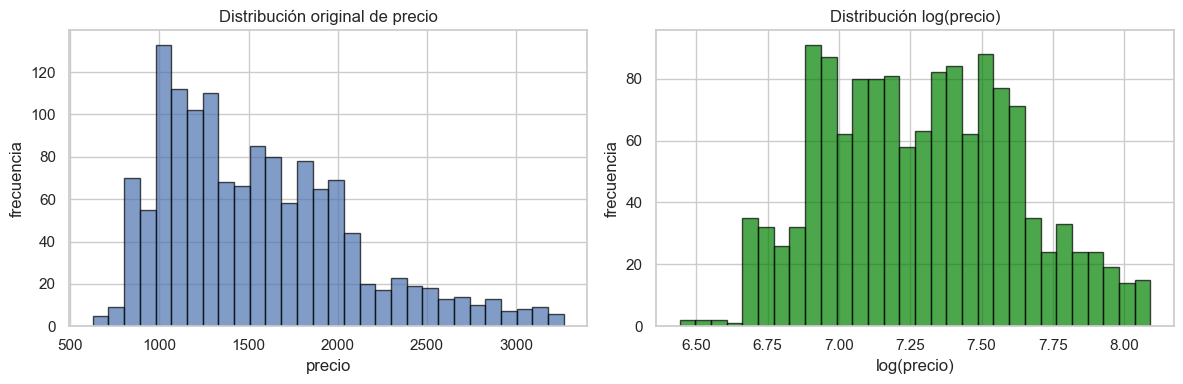

Asimetría (skewness) original: 0.869
Asimetría (skewness) con log: 0.177

Nota: |skewness| < 0.5 indica distribución aproximadamente simétrica


In [11]:
# Analizar distribución del target
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Distribución original
axes[0].hist(y, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribución original de precio')
axes[0].set_xlabel('precio')
axes[0].set_ylabel('frecuencia')

# Distribución con log
y_log = np.log1p(y)
axes[1].hist(y_log, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Distribución log(precio)')
axes[1].set_xlabel('log(precio)')
axes[1].set_ylabel('frecuencia')

plt.tight_layout()
plt.show()

# Calcular asimetría (skewness)
skew_original = stats.skew(y)
skew_log = stats.skew(y_log)

print(f"Asimetría (skewness) original: {skew_original:.3f}")
print(f"Asimetría (skewness) con log: {skew_log:.3f}")
print(f"\nNota: |skewness| < 0.5 indica distribución aproximadamente simétrica")

In [12]:
# Aplicar transformación logarítmica al target
# Usamos log1p (log(1+x)) para manejar posibles valores cercanos a 0

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print("Transformación logarítmica aplicada al target")
print(f"y_train: rango [{y_train.min():.2f}, {y_train.max():.2f}] -> [{y_train_log.min():.2f}, {y_train_log.max():.2f}]")
print(f"y_test: rango [{y_test.min():.2f}, {y_test.max():.2f}] -> [{y_test_log.min():.2f}, {y_test_log.max():.2f}]")

Transformación logarítmica aplicada al target
y_train: rango [648.00, 3267.00] -> [6.48, 8.09]
y_test: rango [626.00, 3224.00] -> [6.44, 8.08]


---
## APARTADO 2: EDA BÁSICO

### 2.1 Análisis de correlaciones (pairplot, heatmaps, etc.)

In [13]:
# Estadísticos descriptivos
df.describe().T

,count,mean,min,25%,50%,75%,max,std
codigo_comunidad,1386.0,10.277778,1.0,6.0,10.5,15.0,19.0,5.497492
year,1386,2012-07-01 05:36:37.402597376,2003-01-01 00:00:00,2007-10-01 00:00:00,2012-07-01 00:00:00,2017-04-01 00:00:00,2022-01-01 00:00:00,NaN
precio,1386.0,1550.49062,626.0,1121.25,1463.0,1866.5,3267.0,533.627206
IPC,1386.0,89.448632,69.256,84.30325,92.2685,95.20225,104.171,7.784031
edad_media,1386.0,42.414603,33.832302,40.531056,42.714297,44.785491,50.330765,3.549302
mano_obra,1386.0,375.498701,313.0,357.1,386.46,395.27,426.92,28.659528
precio_Acero,1386.0,1082.185714,717.4,1013.2,1079.6,1155.0,1689.7,168.495945
precio_Aluminio,1386.0,780.392208,622.9,728.3,775.3,805.4,1124.7,78.733047
precio_Cemento,1386.0,1594.364935,1324.6,1565.8,1630.9,1653.6,1812.3,105.688338
precio_Ceramica,1386.0,1426.131169,1224.4,1421.5,1437.0,1462.9,1855.2,95.532243


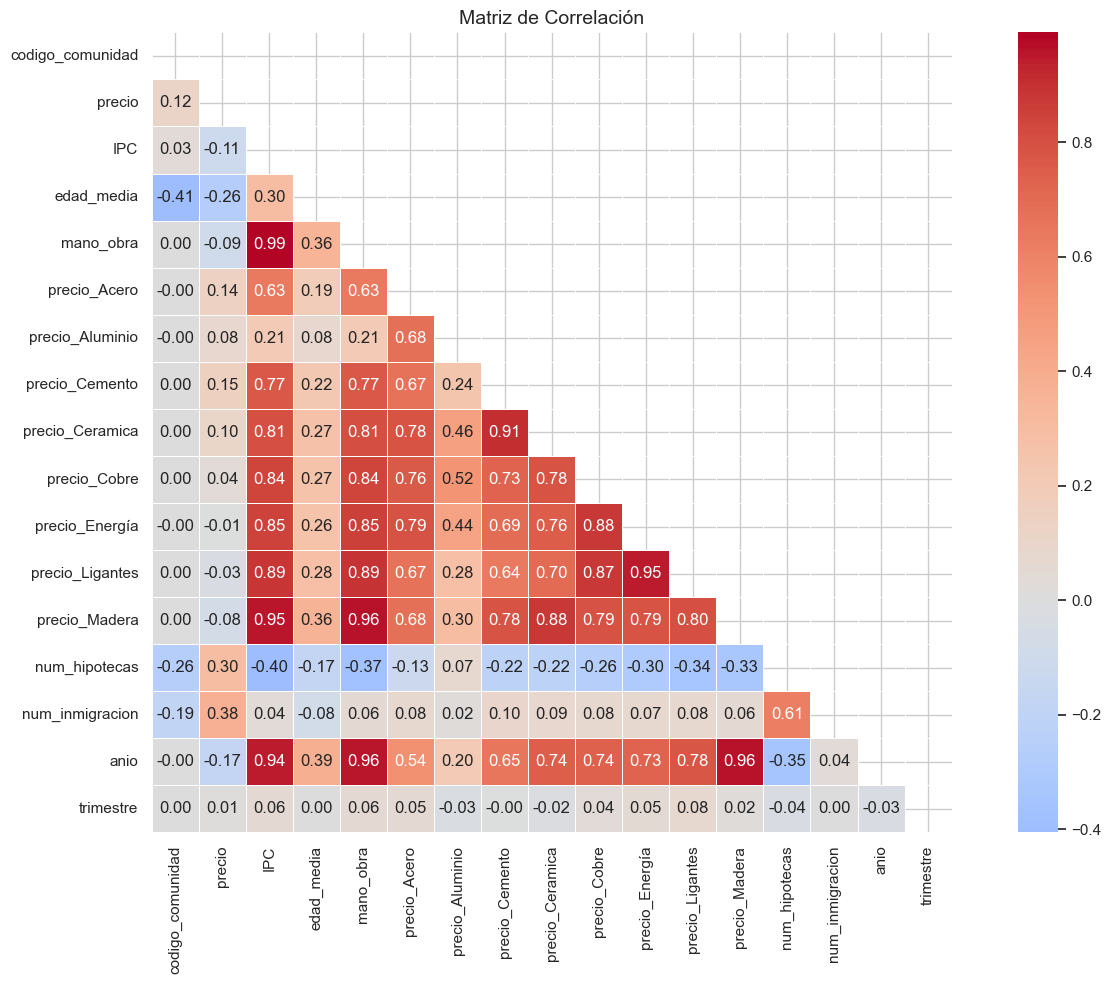

In [14]:
# Matriz de correlación
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Máscara triangular
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', mask=mask, square=True, linewidths=0.5)
plt.title('Matriz de Correlación', fontsize=14)
plt.tight_layout()
plt.show()

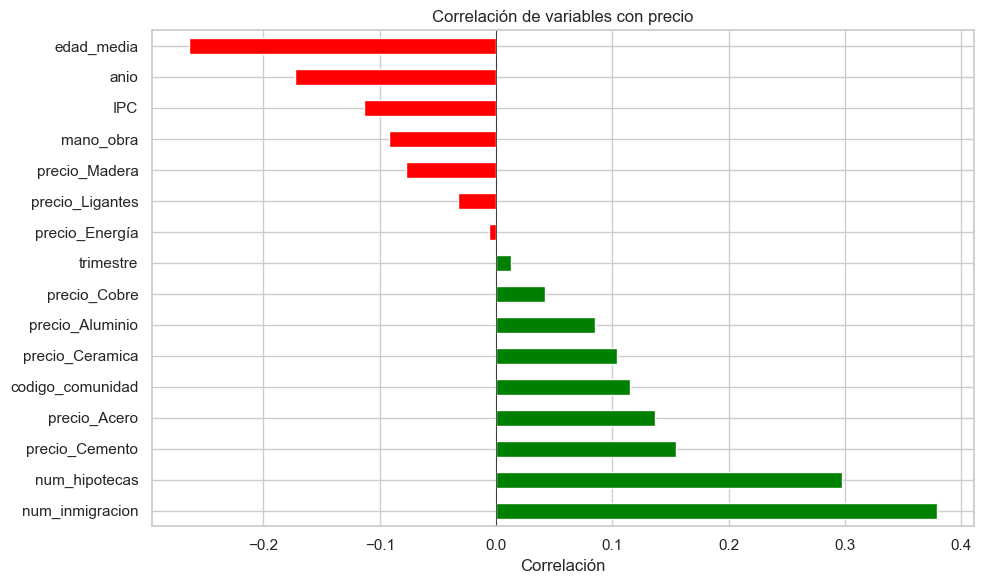

Top 5 variables más correlacionadas (positivamente):
num_inmigracion     0.378738
num_hipotecas       0.297547
precio_Cemento      0.154461
precio_Acero        0.136940
codigo_comunidad    0.115206
Name: precio, dtype: float64

Top 5 variables más correlacionadas (negativamente):
precio_Madera   -0.077606
mano_obra       -0.091684
IPC             -0.113718
anio            -0.172558
edad_media      -0.263972
Name: precio, dtype: float64


In [15]:
# Correlaciones con el target
corr_target = corr_matrix[TARGET].drop(TARGET).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in corr_target.values]
corr_target.plot(kind='barh', color=colors)
plt.title(f'Correlación de variables con {TARGET}')
plt.xlabel('Correlación')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print("Top 5 variables más correlacionadas (positivamente):")
print(corr_target.head())
print("\nTop 5 variables más correlacionadas (negativamente):")
print(corr_target.tail())

Variables seleccionadas para pairplot: ['num_inmigracion', 'num_hipotecas', 'edad_media', 'anio', 'precio']


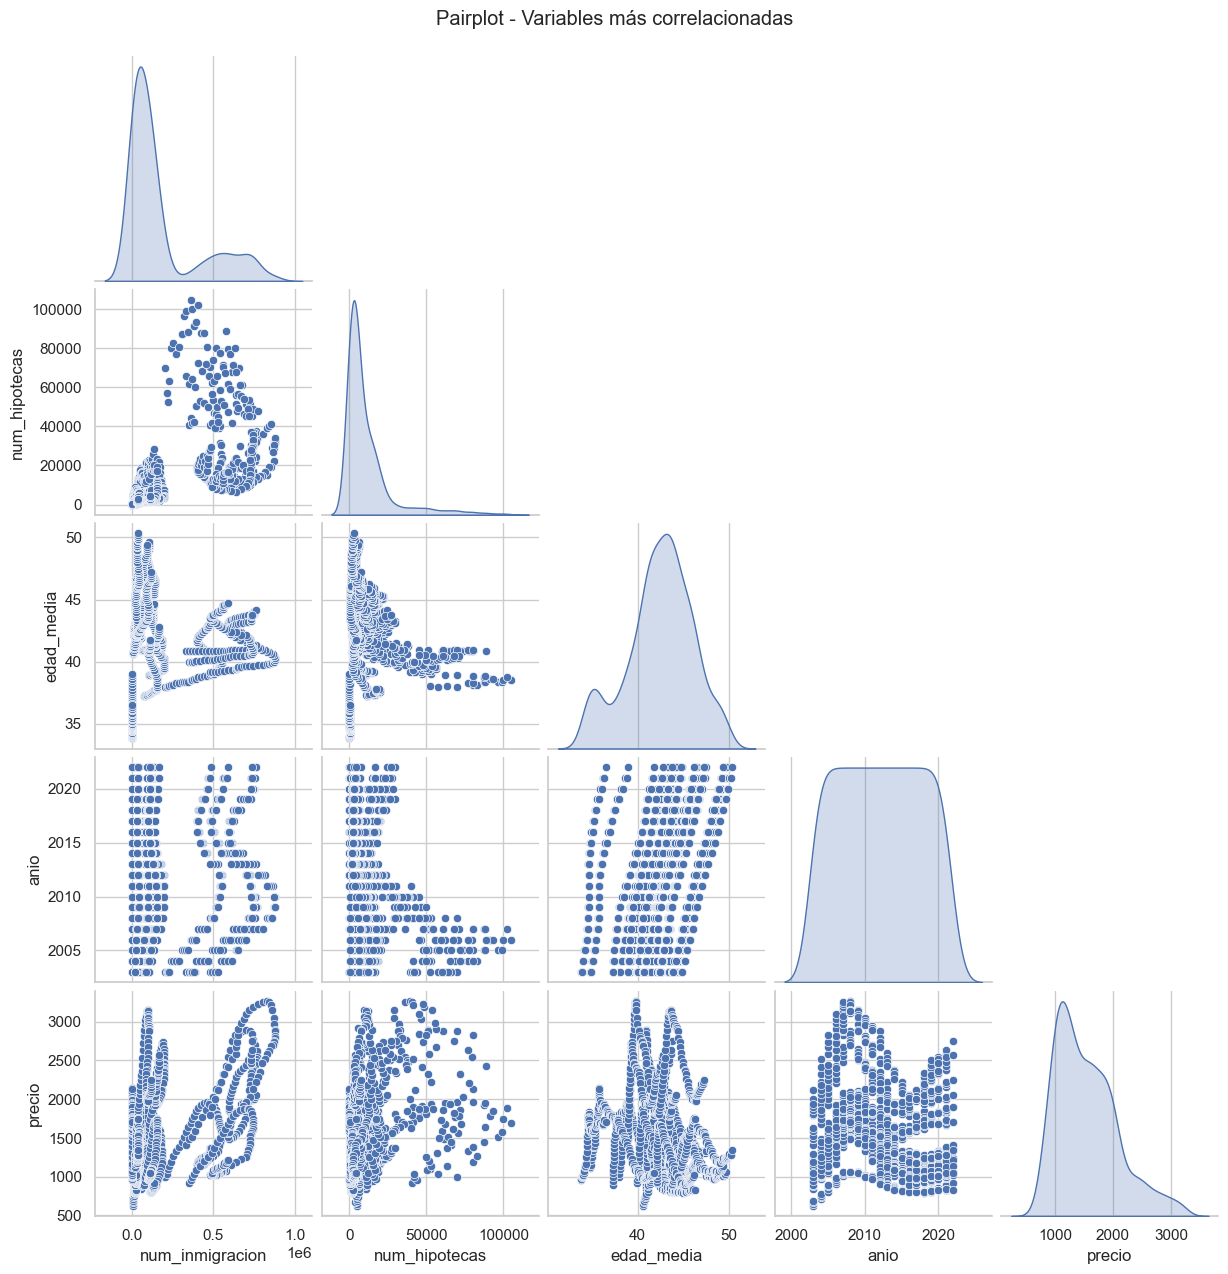

In [16]:
# Pairplot con variables más relevantes
# Seleccionamos las 4 variables más correlacionadas con el target
top_vars = corr_target.abs().sort_values(ascending=False).head(4).index.tolist()
top_vars.append(TARGET)

print(f"Variables seleccionadas para pairplot: {top_vars}")
sns.pairplot(df[top_vars], diag_kind='kde', corner=True)
plt.suptitle('Pairplot - Variables más correlacionadas', y=1.02)
plt.show()

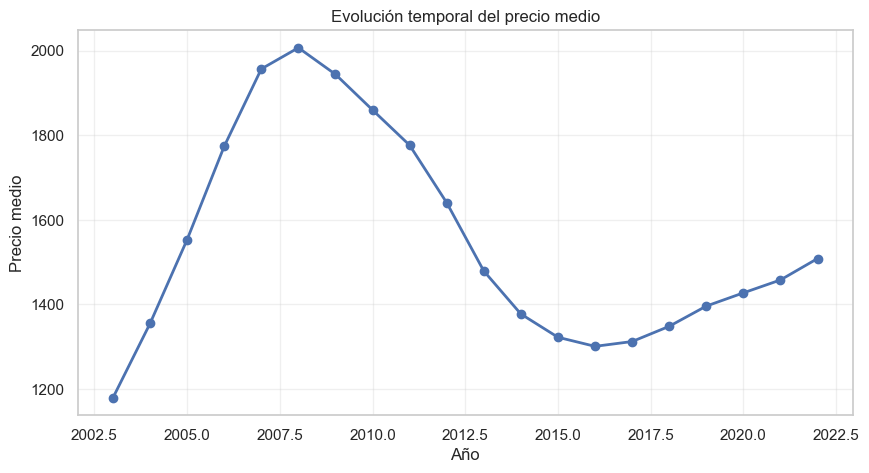

In [17]:
# Evolución temporal del precio
df_temporal = df.groupby('anio')[TARGET].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(df_temporal['anio'], df_temporal[TARGET], marker='o', linewidth=2)
plt.title('Evolución temporal del precio medio')
plt.xlabel('Año')
plt.ylabel('Precio medio')
plt.grid(True, alpha=0.3)
plt.show()

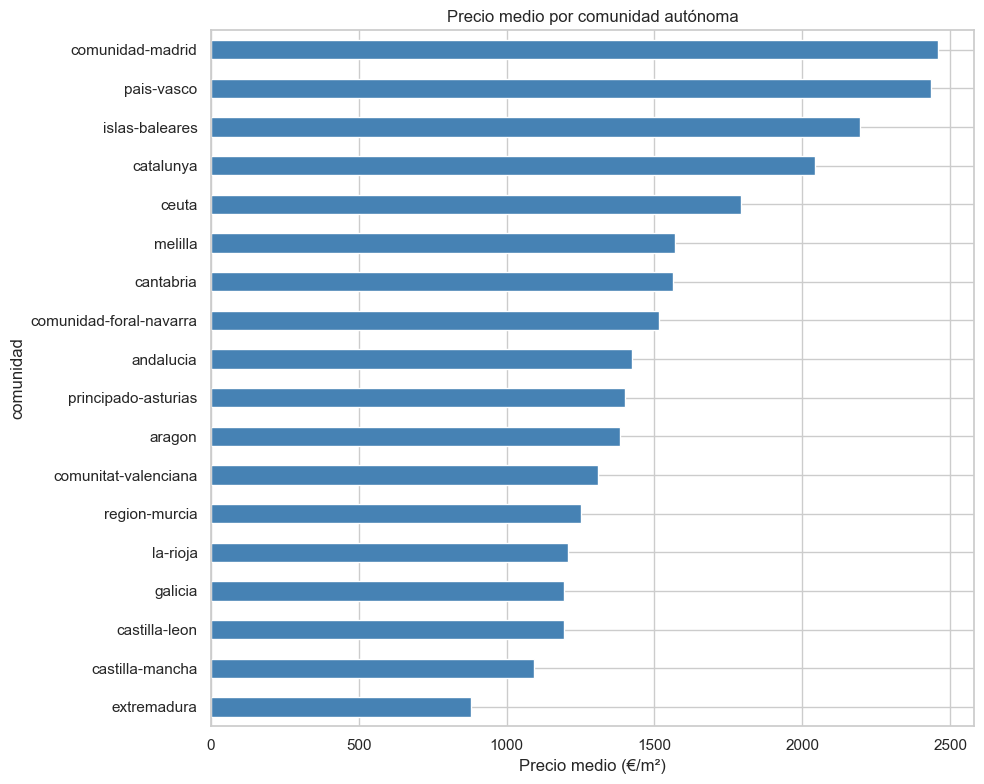

In [18]:
# Precio por comunidad
precio_comunidad = df.groupby('comunidad')[TARGET].mean().sort_values(ascending=True)

plt.figure(figsize=(10, 8))
precio_comunidad.plot(kind='barh', color='steelblue')
plt.title('Precio medio por comunidad autónoma')
plt.xlabel('Precio medio (€/m²)')
plt.tight_layout()
plt.show()

### 2.2 Conclusiones de las relaciones

**Observaciones del EDA:**

1. **Correlaciones fuertes con el precio:**
   - Variables de costes de materiales (Cobre, Energía, Ligantes) muestran alta correlación
   - El IPC y edad_media también correlacionan positivamente
   - num_hipotecas tiene correlación negativa (más hipotecas en épocas de precios más bajos relativos)

2. **Tendencia temporal:**
   - Se observa el ciclo inmobiliario: subida hasta 2007-2008, caída hasta 2014, y recuperación posterior

3. **Diferencias geográficas:**
   - Clara heterogeneidad en precios por comunidad autónoma
   - Justifica incluir la variable categórica 'comunidad' en el modelo

4. **Distribución del target:**
   - Presenta asimetría positiva, lo que justifica la transformación logarítmica

---
## APARTADO 3: ALGORITMOS DE REGRESIÓN

In [19]:
# Funciones auxiliares para evaluación

def r2_ajustada(r2, n, p):
    """Calcula R² ajustada"""
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

def evaluar_modelo(nombre, pipe, X_train, X_test, y_train, y_test, usar_log=True):
    """
    Entrena y evalúa un modelo, devolviendo métricas y predicciones.
    Si usar_log=True, las métricas se calculan en escala original (des-logaritmizada).
    """
    # Entrenar
    pipe.fit(X_train, y_train)
    
    # Predecir
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    # Si usamos log, convertir a escala original para métricas
    if usar_log:
        y_train_real = np.expm1(y_train)
        y_test_real = np.expm1(y_test)
        y_train_pred_real = np.expm1(y_train_pred)
        y_test_pred_real = np.expm1(y_test_pred)
    else:
        y_train_real = y_train
        y_test_real = y_test
        y_train_pred_real = y_train_pred
        y_test_pred_real = y_test_pred
    
    # Calcular métricas en escala original
    mse_train = mean_squared_error(y_train_real, y_train_pred_real)
    mse_test = mean_squared_error(y_test_real, y_test_pred_real)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test_real, y_test_pred_real)
    r2 = r2_score(y_test_real, y_test_pred_real)
    n = len(y_test)
    p = X_test.shape[1]
    r2_adj = r2_ajustada(r2, n, p)
    
    return {
        'Modelo': nombre,
        'MAE': mae_test,
        'MSE': mse_test,
        'RMSE': rmse_test,
        'R2': r2,
        'R2_adj': r2_adj,
        'RMSE_train': rmse_train,
        'y_pred': y_test_pred,
        'y_pred_real': y_test_pred_real,
        'pipeline': pipe
    }

# Almacenar resultados de todos los modelos
resultados = []

### 3.1 Regresión Lineal Simple

Usamos **una sola variable** (la más correlacionada con el target) para ilustrar regresión simple.

In [20]:
# Seleccionar la variable numérica más correlacionada
var_simple = corr_target.abs().idxmax()
print(f"Variable seleccionada para regresión simple: {var_simple}")
print(f"Correlación con {TARGET}: {corr_target[var_simple]:.3f}")

# Preparar datos para regresión simple
X_simple = X[[var_simple]]
X_train_simple, X_test_simple, y_train_simple_log, y_test_simple_log = train_test_split(
    X_simple, np.log1p(y), test_size=0.2, random_state=42
)

# Pipeline simple (solo escalado de la variable numérica)
pipe_simple = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

# Entrenar y evaluar
res_simple = evaluar_modelo(
    'Regresión Lineal Simple', pipe_simple,
    X_train_simple, X_test_simple, 
    y_train_simple_log, y_test_simple_log,
    usar_log=True
)

print(f"\nResultados Regresión Simple:")
print(f"  RMSE: {res_simple['RMSE']:.2f}")
print(f"  R²: {res_simple['R2']:.4f}")
print(f"  R² ajustada: {res_simple['R2_adj']:.4f}")

Variable seleccionada para regresión simple: num_inmigracion
Correlación con precio: 0.379

Resultados Regresión Simple:
  RMSE: 507.77
  R²: 0.1408
  R² ajustada: 0.1377


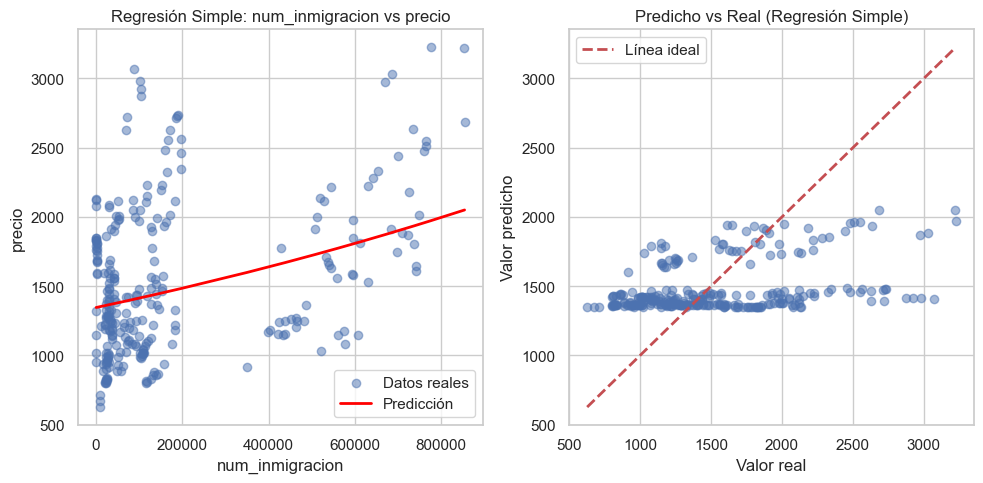

In [21]:
# Visualizar regresión simple
y_test_simple_real = np.expm1(y_test_simple_log)

plt.figure(figsize=(10, 5))

# Scatter con línea de regresión
plt.subplot(1, 2, 1)
plt.scatter(X_test_simple, y_test_simple_real, alpha=0.5, label='Datos reales')
# Ordenar para la línea
idx_sort = X_test_simple[var_simple].argsort()
plt.plot(X_test_simple.iloc[idx_sort], res_simple['y_pred_real'][idx_sort], 
         color='red', linewidth=2, label='Predicción')
plt.xlabel(var_simple)
plt.ylabel(TARGET)
plt.title(f'Regresión Simple: {var_simple} vs {TARGET}')
plt.legend()

# Predicho vs Real
plt.subplot(1, 2, 2)
plt.scatter(y_test_simple_real, res_simple['y_pred_real'], alpha=0.5)
plt.plot([y_test_simple_real.min(), y_test_simple_real.max()], 
         [y_test_simple_real.min(), y_test_simple_real.max()], 
         'r--', linewidth=2, label='Línea ideal')
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.title('Predicho vs Real (Regresión Simple)')
plt.legend()

plt.tight_layout()
plt.show()

### 3.2 Regresión Lineal Múltiple

Usamos **todas las variables** (numéricas + categóricas codificadas).

In [22]:
# Pipeline con preprocesador completo
pipe_lineal = Pipeline([
    ('prep', preprocessor),
    ('reg', LinearRegression())
])

res_lineal = evaluar_modelo(
    'Regresión Lineal Múltiple', pipe_lineal,
    X_train, X_test, y_train_log, y_test_log,
    usar_log=True
)
resultados.append(res_lineal)

print(f"Resultados Regresión Lineal Múltiple:")
print(f"  MAE: {res_lineal['MAE']:.2f}")
print(f"  RMSE: {res_lineal['RMSE']:.2f}")
print(f"  R²: {res_lineal['R2']:.4f}")
print(f"  R² ajustada: {res_lineal['R2_adj']:.4f}")

Resultados Regresión Lineal Múltiple:
  MAE: 110.23
  RMSE: 143.94
  R²: 0.9310
  R² ajustada: 0.9264


### 3.3 Regresión Polinomial

Añadimos términos polinomiales (grado 2) para capturar relaciones no lineales.

In [23]:
# Pipeline con features polinomiales
pipe_poly = Pipeline([
    ('prep', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('reg', LinearRegression())
])

res_poly = evaluar_modelo(
    'Regresión Polinomial (grado 2)', pipe_poly,
    X_train, X_test, y_train_log, y_test_log,
    usar_log=True
)
resultados.append(res_poly)

print(f"Resultados Regresión Polinomial:")
print(f"  MAE: {res_poly['MAE']:.2f}")
print(f"  RMSE: {res_poly['RMSE']:.2f}")
print(f"  R²: {res_poly['R2']:.4f}")
print(f"  R² ajustada: {res_poly['R2_adj']:.4f}")

Resultados Regresión Polinomial:
  MAE: 23.66
  RMSE: 33.12
  R²: 0.9963
  R² ajustada: 0.9961


### 3.4 Generar / Aplicar predicciones

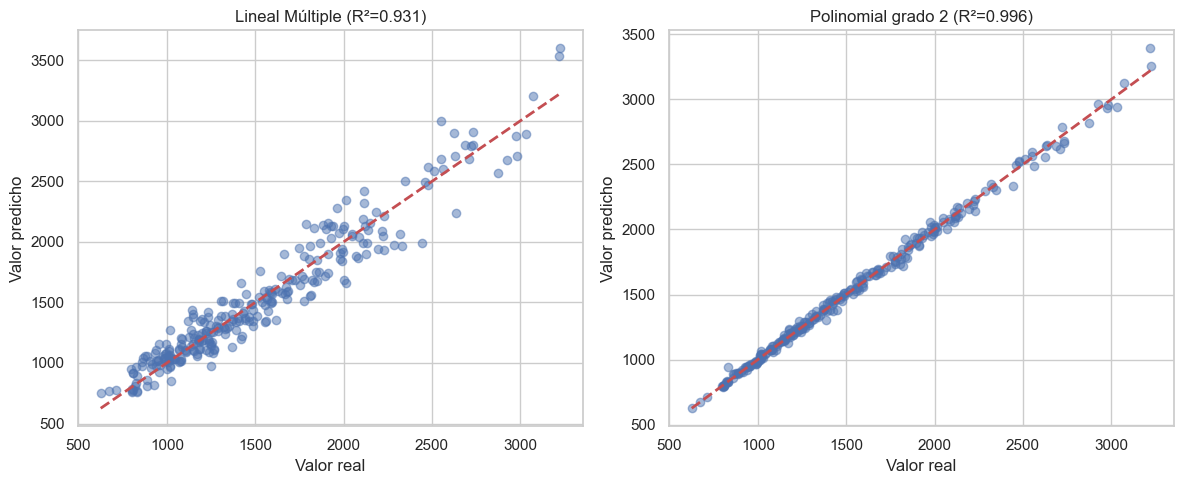

In [24]:
# Comparar predicciones de los modelos de regresión
y_test_real = np.expm1(y_test_log)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Regresión Lineal Múltiple
axes[0].scatter(y_test_real, res_lineal['y_pred_real'], alpha=0.5)
axes[0].plot([y_test_real.min(), y_test_real.max()], 
             [y_test_real.min(), y_test_real.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Valor real')
axes[0].set_ylabel('Valor predicho')
axes[0].set_title(f'Lineal Múltiple (R²={res_lineal["R2"]:.3f})')

# Regresión Polinomial
axes[1].scatter(y_test_real, res_poly['y_pred_real'], alpha=0.5)
axes[1].plot([y_test_real.min(), y_test_real.max()], 
             [y_test_real.min(), y_test_real.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Valor real')
axes[1].set_ylabel('Valor predicho')
axes[1].set_title(f'Polinomial grado 2 (R²={res_poly["R2"]:.3f})')

plt.tight_layout()
plt.show()

---
## APARTADO 4: ALGORITMOS SVM

### 4.1 Aplicar Support Vector Machines y generar predicciones

In [25]:
# SVR (Support Vector Regression) con kernel RBF
pipe_svr = Pipeline([
    ('prep', preprocessor),
    ('reg', SVR(kernel='rbf', C=100, epsilon=0.1))
])

res_svr = evaluar_modelo(
    'SVM (SVR kernel RBF)', pipe_svr,
    X_train, X_test, y_train_log, y_test_log,
    usar_log=True
)
resultados.append(res_svr)

print(f"Resultados SVR:")
print(f"  MAE: {res_svr['MAE']:.2f}")
print(f"  RMSE: {res_svr['RMSE']:.2f}")
print(f"  R²: {res_svr['R2']:.4f}")
print(f"  R² ajustada: {res_svr['R2_adj']:.4f}")

Resultados SVR:
  MAE: 104.46
  RMSE: 137.65
  R²: 0.9369
  R² ajustada: 0.9327


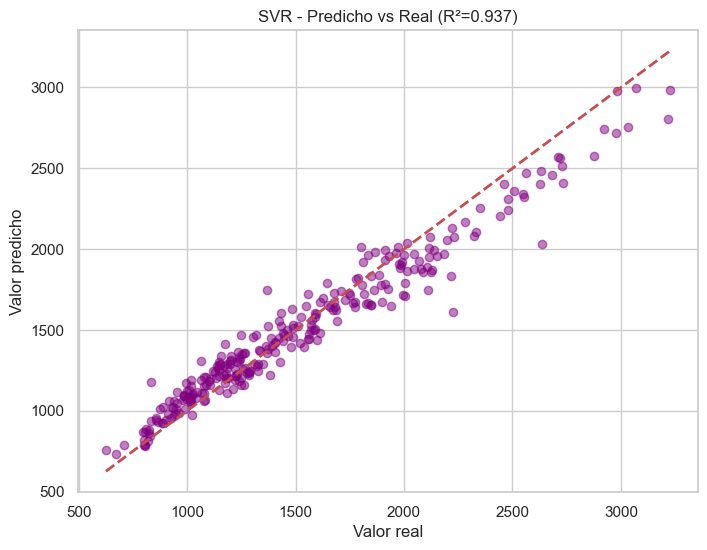

In [26]:
# Visualizar predicciones SVR
plt.figure(figsize=(8, 6))
plt.scatter(y_test_real, res_svr['y_pred_real'], alpha=0.5, color='purple')
plt.plot([y_test_real.min(), y_test_real.max()], 
         [y_test_real.min(), y_test_real.max()], 'r--', linewidth=2)
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.title(f'SVR - Predicho vs Real (R²={res_svr["R2"]:.3f})')
plt.show()

---
## APARTADO 5: ALGORITMOS ÁRBOLES DE DECISIÓN

### 5.1 Aplicar DecisionTrees y generar predicciones

In [27]:
# Decision Tree Regressor
pipe_tree = Pipeline([
    ('prep', preprocessor),
    ('reg', DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, random_state=42))
])

res_tree = evaluar_modelo(
    'Árbol de Decisión', pipe_tree,
    X_train, X_test, y_train_log, y_test_log,
    usar_log=True
)
resultados.append(res_tree)

print(f"Resultados Árbol de Decisión:")
print(f"  MAE: {res_tree['MAE']:.2f}")
print(f"  RMSE: {res_tree['RMSE']:.2f}")
print(f"  R²: {res_tree['R2']:.4f}")
print(f"  R² ajustada: {res_tree['R2_adj']:.4f}")

Resultados Árbol de Decisión:
  MAE: 98.28
  RMSE: 151.98
  R²: 0.9230
  R² ajustada: 0.9180


In [28]:
# Random Forest (ensemble de árboles)
pipe_rf = Pipeline([
    ('prep', preprocessor),
    ('reg', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1))
])

res_rf = evaluar_modelo(
    'Random Forest', pipe_rf,
    X_train, X_test, y_train_log, y_test_log,
    usar_log=True
)
resultados.append(res_rf)

print(f"Resultados Random Forest:")
print(f"  MAE: {res_rf['MAE']:.2f}")
print(f"  RMSE: {res_rf['RMSE']:.2f}")
print(f"  R²: {res_rf['R2']:.4f}")
print(f"  R² ajustada: {res_rf['R2_adj']:.4f}")

Resultados Random Forest:
  MAE: 41.59
  RMSE: 68.12
  R²: 0.9845
  R² ajustada: 0.9835


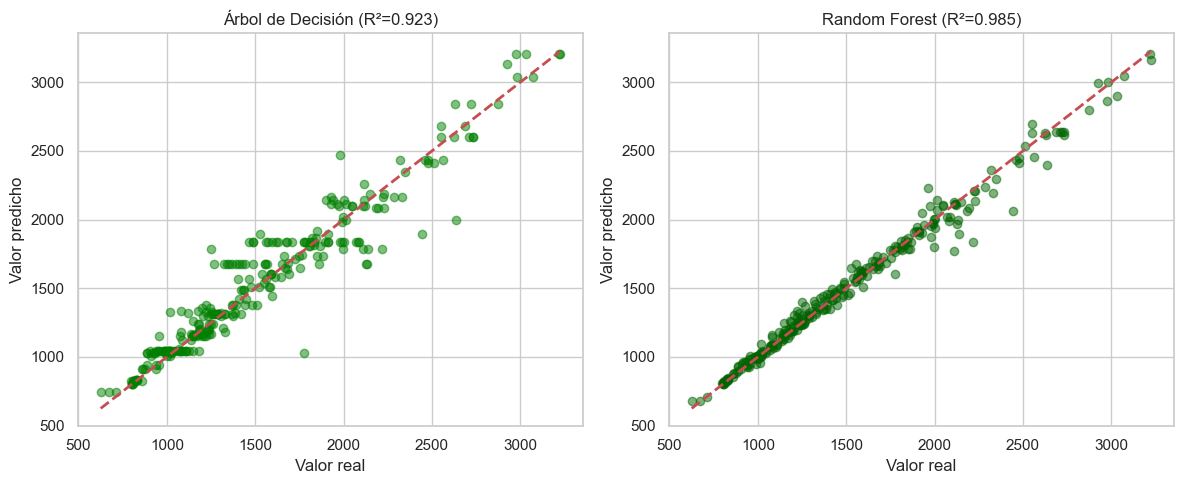

In [29]:
# Visualizar predicciones de árboles
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Árbol de Decisión
axes[0].scatter(y_test_real, res_tree['y_pred_real'], alpha=0.5, color='green')
axes[0].plot([y_test_real.min(), y_test_real.max()], 
             [y_test_real.min(), y_test_real.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Valor real')
axes[0].set_ylabel('Valor predicho')
axes[0].set_title(f'Árbol de Decisión (R²={res_tree["R2"]:.3f})')

# Random Forest
axes[1].scatter(y_test_real, res_rf['y_pred_real'], alpha=0.5, color='darkgreen')
axes[1].plot([y_test_real.min(), y_test_real.max()], 
             [y_test_real.min(), y_test_real.max()], 'r--', linewidth=2)
axes[1].set_xlabel('Valor real')
axes[1].set_ylabel('Valor predicho')
axes[1].set_title(f'Random Forest (R²={res_rf["R2"]:.3f})')

plt.tight_layout()
plt.show()

---
## APARTADO 6: CONCLUSIONES

### 6.1 Representar error en predicciones (residuo) frente a valor predicho

El análisis de residuos nos permite verificar los supuestos del modelo:
- **Homocedasticidad**: Los residuos deben tener varianza constante
- **No debe haber patrones**: Un buen modelo muestra residuos distribuidos aleatoriamente

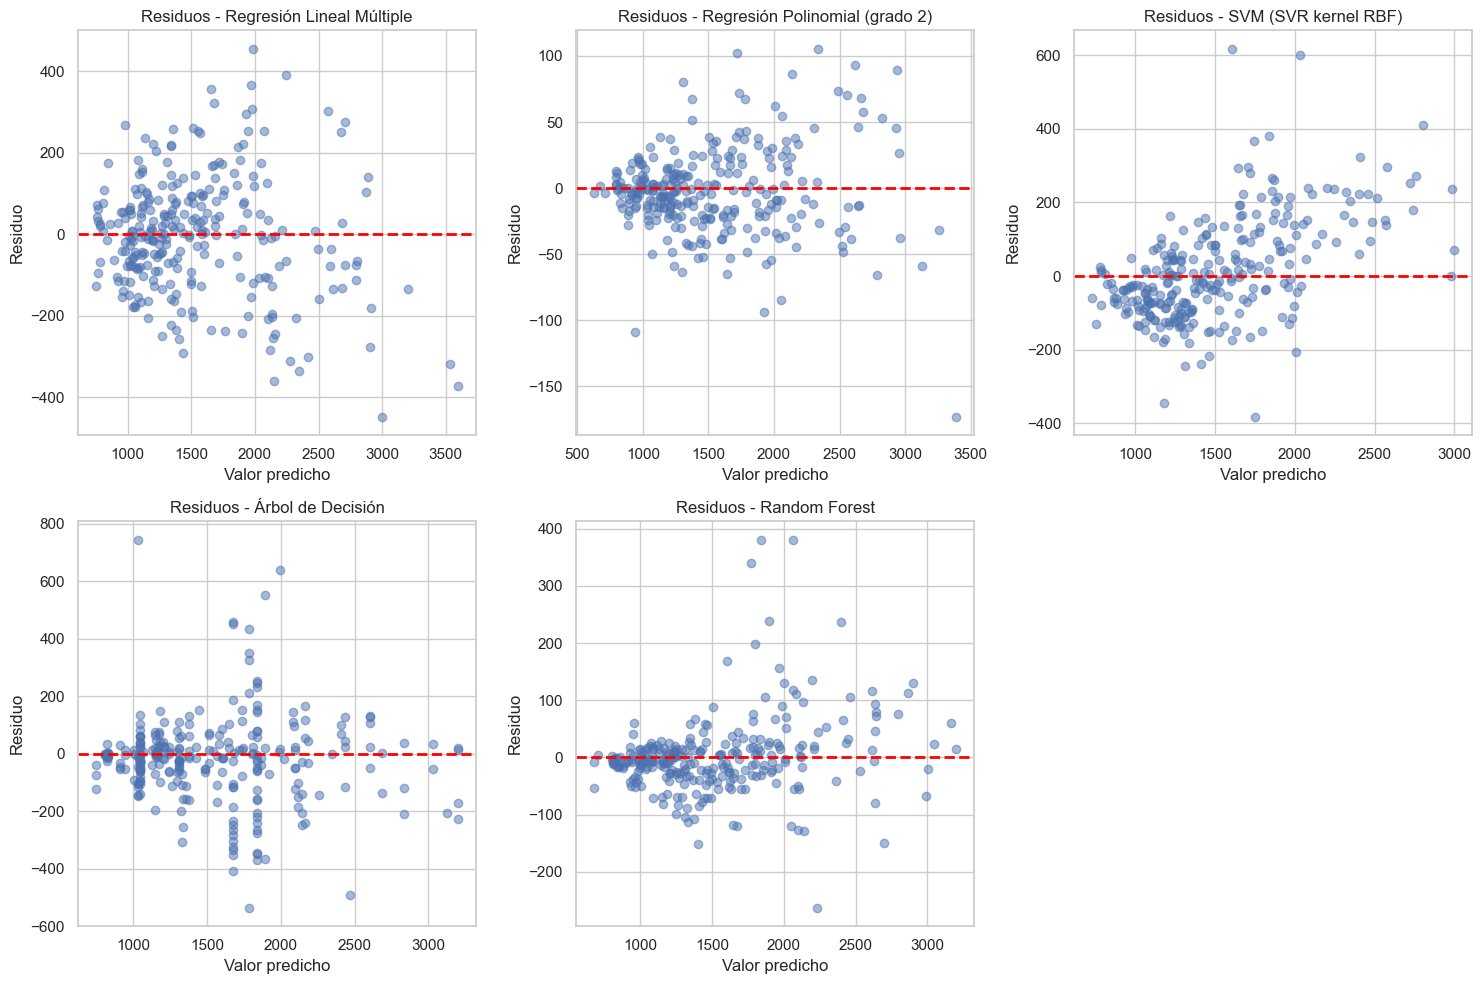

In [30]:
# Gráficos de residuos para todos los modelos
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, res in enumerate(resultados):
    residuos = y_test_real.values - res['y_pred_real']
    
    axes[i].scatter(res['y_pred_real'], residuos, alpha=0.5)
    axes[i].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[i].set_xlabel('Valor predicho')
    axes[i].set_ylabel('Residuo')
    axes[i].set_title(f'Residuos - {res["Modelo"]}')

# Ocultar el último subplot si hay menos modelos
if len(resultados) < 6:
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

### 6.2 Representar / Determinar si hay overfitting

**Overfitting** ocurre cuando el modelo memoriza los datos de entrenamiento pero no generaliza bien a datos nuevos. Se detecta comparando el error en train vs test.

In [31]:
# Comparar RMSE train vs test para detectar overfitting
print("Comparación RMSE Train vs Test (detección de overfitting):")
print("-" * 70)
print(f"{'Modelo':<30} {'RMSE Train':>12} {'RMSE Test':>12} {'Ratio':>10} {'Overfitting?':>12}")
print("-" * 70)

for res in resultados:
    ratio = res['RMSE'] / res['RMSE_train'] if res['RMSE_train'] > 0 else float('inf')
    # Consideramos overfitting si test es >50% peor que train
    overfit = "SÍ" if ratio > 1.5 else "NO"
    print(f"{res['Modelo']:<30} {res['RMSE_train']:>12.2f} {res['RMSE']:>12.2f} {ratio:>10.2f} {overfit:>12}")

Comparación RMSE Train vs Test (detección de overfitting):
----------------------------------------------------------------------
Modelo                           RMSE Train    RMSE Test      Ratio Overfitting?
----------------------------------------------------------------------
Regresión Lineal Múltiple            143.04       143.94       1.01           NO
Regresión Polinomial (grado 2)        21.04        33.12       1.57           SÍ
SVM (SVR kernel RBF)                 114.46       137.65       1.20           NO
Árbol de Decisión                    110.29       151.98       1.38           NO
Random Forest                         26.90        68.12       2.53           SÍ


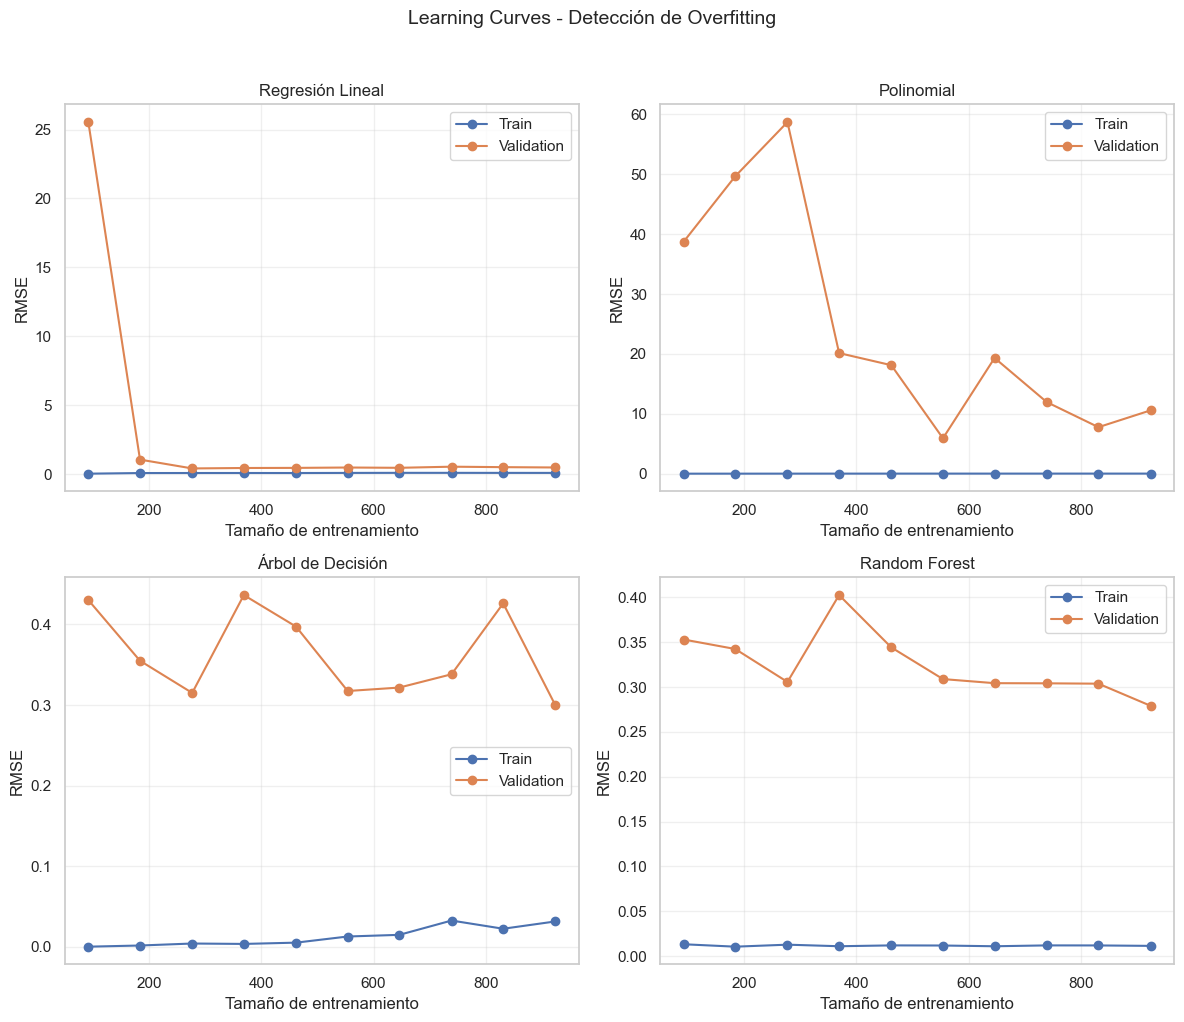


Interpretación:
- Si las curvas convergen: buen ajuste
- Si train << validation con gap grande: underfitting
- Si train >> validation con gap grande: overfitting


In [32]:
# Learning curves para visualizar overfitting
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_root_mean_squared_error'
    )
    
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Train')
    plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation')
    plt.xlabel('Tamaño de entrenamiento')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)

# Crear pipelines sin entrenar para learning curves
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

modelos_lc = [
    ('Regresión Lineal', Pipeline([('prep', preprocessor), ('reg', LinearRegression())])),
    ('Polinomial', Pipeline([('prep', preprocessor), ('poly', PolynomialFeatures(2)), ('reg', LinearRegression())])),
    ('Árbol de Decisión', Pipeline([('prep', preprocessor), ('reg', DecisionTreeRegressor(max_depth=10, random_state=42))])),
    ('Random Forest', Pipeline([('prep', preprocessor), ('reg', RandomForestRegressor(n_estimators=50, random_state=42))]))
]

for ax, (nombre, modelo) in zip(axes.flatten(), modelos_lc):
    plt.sca(ax)
    plot_learning_curve(modelo, nombre, X, y_log, cv=3)

plt.suptitle('Learning Curves - Detección de Overfitting', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nInterpretación:")
print("- Si las curvas convergen: buen ajuste")
print("- Si train << validation con gap grande: underfitting")
print("- Si train >> validation con gap grande: overfitting")

### 6.3 Normalizar distribución

**Nota:** La transformación logarítmica ya se aplicó en el Apartado 1.6. Aquí verificamos el efecto en los residuos.

Mejor modelo: Regresión Polinomial (grado 2)


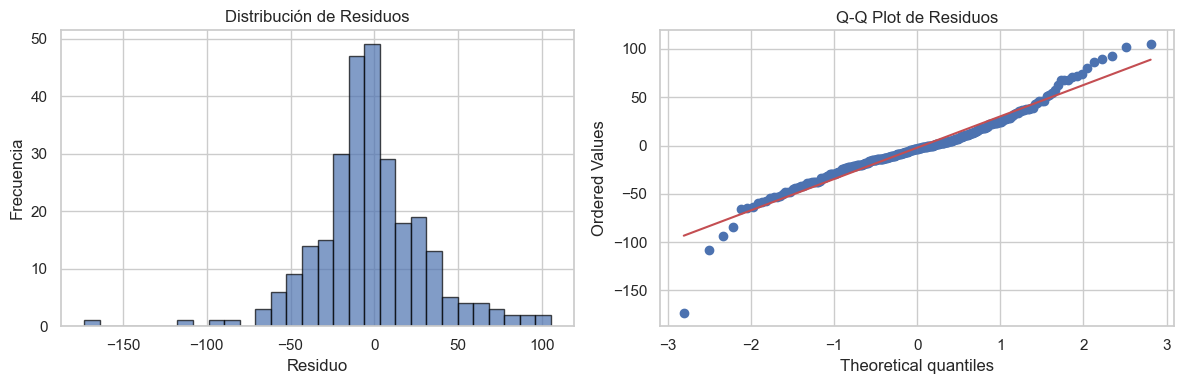


Test de Shapiro-Wilk:
  Estadístico: 0.9539
  p-valor: 0.0000
  Conclusión: Residuos no normales (α=0.05)


In [33]:
# Verificar normalidad de residuos del mejor modelo
from scipy import stats

# Seleccionar el mejor modelo (menor RMSE)
mejor = min(resultados, key=lambda x: x['RMSE'])
print(f"Mejor modelo: {mejor['Modelo']}")

residuos_mejor = y_test_real.values - mejor['y_pred_real']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograma de residuos
axes[0].hist(residuos_mejor, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Residuo')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Residuos')

# Q-Q plot
stats.probplot(residuos_mejor, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot de Residuos')

plt.tight_layout()
plt.show()

# Test de normalidad
stat, p_value = stats.shapiro(residuos_mejor[:min(5000, len(residuos_mejor))])
print(f"\nTest de Shapiro-Wilk:")
print(f"  Estadístico: {stat:.4f}")
print(f"  p-valor: {p_value:.4f}")
print(f"  Conclusión: {'Residuos aproximadamente normales' if p_value > 0.05 else 'Residuos no normales'} (α=0.05)")

### 6.4 Aplicar métricas - Comparar entre algoritmos

In [34]:
# Crear DataFrame de resultados
df_resultados = pd.DataFrame([{
    'Modelo': r['Modelo'],
    'MAE': r['MAE'],
    'MSE': r['MSE'],
    'RMSE': r['RMSE'],
    'R²': r['R2'],
    'R² Ajustada': r['R2_adj']
} for r in resultados])

# Ordenar por RMSE
df_resultados = df_resultados.sort_values('RMSE').reset_index(drop=True)

print("=" * 80)
print("COMPARACIÓN DE ALGORITMOS")
print("=" * 80)
display(df_resultados.style.highlight_min(subset=['MAE', 'MSE', 'RMSE'], color='orange')
                          .highlight_max(subset=['R²', 'R² Ajustada'], color='red')
                          .format({'MAE': '{:.2f}', 'MSE': '{:.2f}', 'RMSE': '{:.2f}', 
                                   'R²': '{:.4f}', 'R² Ajustada': '{:.4f}'}))

COMPARACIÓN DE ALGORITMOS


,Modelo,MAE,MSE,RMSE,R²,R² Ajustada
0,Regresión Polinomial (grado 2),23.66,1096.84,33.12,0.9963,0.9961
1,Random Forest,41.59,4640.12,68.12,0.9845,0.9835
2,SVM (SVR kernel RBF),104.46,18948.59,137.65,0.9369,0.9327
3,Regresión Lineal Múltiple,110.23,20717.40,143.94,0.9310,0.9264
4,Árbol de Decisión,98.28,23097.10,151.98,0.9230,0.9180


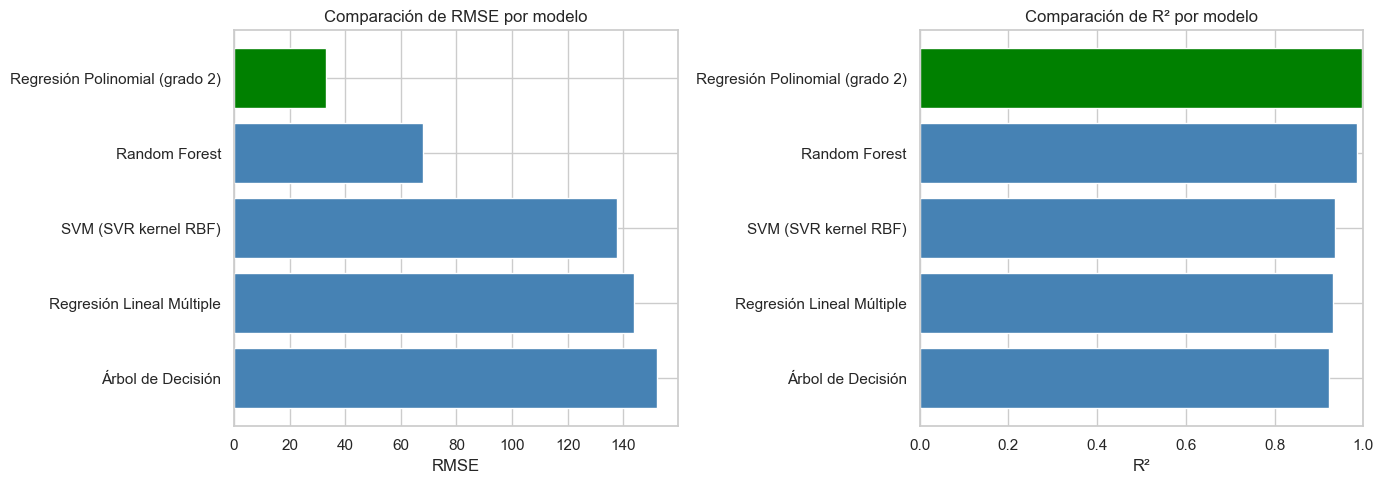

In [35]:
# Visualización de la comparación
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras para RMSE
colors = ['green' if x == df_resultados['RMSE'].min() else 'steelblue' for x in df_resultados['RMSE']]
axes[0].barh(df_resultados['Modelo'], df_resultados['RMSE'], color=colors)
axes[0].set_xlabel('RMSE')
axes[0].set_title('Comparación de RMSE por modelo')
axes[0].invert_yaxis()

# Gráfico de barras para R²
colors = ['green' if x == df_resultados['R²'].max() else 'steelblue' for x in df_resultados['R²']]
axes[1].barh(df_resultados['Modelo'], df_resultados['R²'], color=colors)
axes[1].set_xlabel('R²')
axes[1].set_title('Comparación de R² por modelo')
axes[1].invert_yaxis()
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()

### 6.5 Ver RMSE / MAE / MSE - Explicación de métricas, R² y R² ajustada

**Métricas de error:**

| Métrica | Fórmula | Interpretación |
|---------|---------|----------------|
| **MAE** (Mean Absolute Error) | $\frac{1}{n}\sum|y_i - \hat{y}_i|$ | Error promedio en las mismas unidades que el target. Robusto a outliers. |
| **MSE** (Mean Squared Error) | $\frac{1}{n}\sum(y_i - \hat{y}_i)^2$ | Error cuadrático promedio. Penaliza más los errores grandes. |
| **RMSE** (Root MSE) | $\sqrt{MSE}$ | Raíz del MSE. En las mismas unidades que el target. |

**Métricas de bondad de ajuste:**

| Métrica | Fórmula | Interpretación |
|---------|---------|----------------|
| **R²** (Coeficiente de determinación) | $1 - \frac{SS_{res}}{SS_{tot}}$ | Proporción de varianza explicada. Rango [0,1], mayor es mejor. |
| **R² Ajustada** | $1 - (1-R^2)\frac{n-1}{n-p-1}$ | R² penalizado por el número de variables. Evita sobreestimación. |

In [36]:
# Demostración visual de las métricas
print("RESUMEN DE MÉTRICAS DEL MEJOR MODELO")
print("=" * 50)
print(f"Modelo: {mejor['Modelo']}")
print(f"\nMétricas de error (en €/m²):")
print(f"  MAE:  {mejor['MAE']:.2f} €/m² (error absoluto promedio)")
print(f"  RMSE: {mejor['RMSE']:.2f} €/m² (desviación típica del error)")
print(f"  MSE:  {mejor['MSE']:.2f} €²/m⁴ (varianza del error)")
print(f"\nMétricas de bondad de ajuste:")
print(f"  R²:         {mejor['R2']:.4f} ({mejor['R2']*100:.2f}% de varianza explicada)")
print(f"  R² ajustada: {mejor['R2_adj']:.4f}")

RESUMEN DE MÉTRICAS DEL MEJOR MODELO
Modelo: Regresión Polinomial (grado 2)

Métricas de error (en €/m²):
  MAE:  23.66 €/m² (error absoluto promedio)
  RMSE: 33.12 €/m² (desviación típica del error)
  MSE:  1096.84 €²/m⁴ (varianza del error)

Métricas de bondad de ajuste:
  R²:         0.9963 (99.63% de varianza explicada)
  R² ajustada: 0.9961


### 6.6 Final - Generar predicciones, aplicando media de resultados (Ensemble)

In [37]:
# Ensemble: Media de predicciones de todos los modelos
predicciones = np.array([r['y_pred_real'] for r in resultados])
ensemble_pred = np.mean(predicciones, axis=0)

# Métricas del ensemble
mae_ensemble = mean_absolute_error(y_test_real, ensemble_pred)
rmse_ensemble = np.sqrt(mean_squared_error(y_test_real, ensemble_pred))
r2_ensemble = r2_score(y_test_real, ensemble_pred)

print("ENSEMBLE (Media de predicciones de todos los modelos)")
print("=" * 50)
print(f"MAE:  {mae_ensemble:.2f}")
print(f"RMSE: {rmse_ensemble:.2f}")
print(f"R²:   {r2_ensemble:.4f}")

# Comparar con el mejor modelo individual
print(f"\nComparación con mejor modelo individual ({mejor['Modelo']}):")
mejora_rmse = (mejor['RMSE'] - rmse_ensemble) / mejor['RMSE'] * 100
print(f"  Diferencia RMSE: {mejora_rmse:+.2f}%")

ENSEMBLE (Media de predicciones de todos los modelos)
MAE:  51.59
RMSE: 72.98
R²:   0.9822

Comparación con mejor modelo individual (Regresión Polinomial (grado 2)):
  Diferencia RMSE: -120.36%


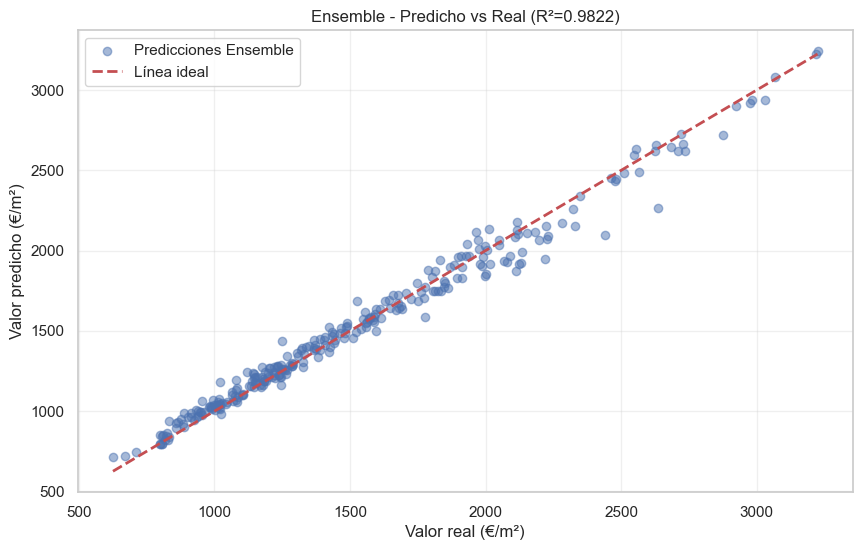

In [38]:
# Visualización del ensemble
plt.figure(figsize=(10, 6))
plt.scatter(y_test_real, ensemble_pred, alpha=0.5, label='Predicciones Ensemble')
plt.plot([y_test_real.min(), y_test_real.max()], 
         [y_test_real.min(), y_test_real.max()], 'r--', linewidth=2, label='Línea ideal')
plt.xlabel('Valor real (€/m²)')
plt.ylabel('Valor predicho (€/m²)')
plt.title(f'Ensemble - Predicho vs Real (R²={r2_ensemble:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [39]:
# Predicción para nuevos datos de ejemplo
print("PREDICCIÓN PARA NUEVOS VALORES")
print("=" * 50)

# Crear un ejemplo modificando una fila existente
nuevo_ejemplo = X.iloc[[0]].copy()
print(f"\nValores originales del ejemplo:")
print(nuevo_ejemplo.T)

# Predecir con cada modelo
print(f"\nPredicciones por modelo:")
preds_nuevos = []
for res in resultados:
    pipe = res['pipeline']
    pred_log = pipe.predict(nuevo_ejemplo)
    pred_real = np.expm1(pred_log)[0]
    preds_nuevos.append(pred_real)
    print(f"  {res['Modelo']:<30}: {pred_real:.2f} €/m²")

# Media ensemble
pred_ensemble = np.mean(preds_nuevos)
print(f"\n  {'ENSEMBLE (media)':<30}: {pred_ensemble:.2f} €/m²")

PREDICCIÓN PARA NUEVOS VALORES

Valores originales del ejemplo:
                          0
codigo_comunidad          1
comunidad         andalucia
IPC                  72.838
edad_media        37.951542
mano_obra             313.0
precio_Acero          719.9
precio_Aluminio       725.8
precio_Cemento       1349.9
precio_Ceramica      1227.4
precio_Cobre          558.2
precio_Energía       2017.0
precio_Ligantes      1453.9
precio_Madera        1507.4
num_hipotecas         69821
num_inmigracion      205704
anio                   2003
trimestre                 1

Predicciones por modelo:
  Regresión Lineal Múltiple     : 1172.48 €/m²
  Regresión Polinomial (grado 2): 1020.85 €/m²
  SVM (SVR kernel RBF)          : 1100.09 €/m²
  Árbol de Decisión             : 1031.77 €/m²
  Random Forest                 : 1039.20 €/m²

  ENSEMBLE (media)              : 1072.88 €/m²


In [40]:
# Predicción para la Región de Murcia
print("PREDICCIÓN PARA LA REGIÓN DE MURCIA")
print("=" * 50)

# Filtrar una fila de Murcia
ejemplo_murcia = X[X['comunidad'] == 'region-murcia'].iloc[[0]].copy()
print(f"\nValores del ejemplo (Murcia):")
print(ejemplo_murcia.T)

# Predecir con cada modelo
print(f"\nPredicciones por modelo:")
preds_murcia = []
for res in resultados:
    pipe = res['pipeline']
    pred_log = pipe.predict(ejemplo_murcia)
    pred_real = np.expm1(pred_log)[0]
    preds_murcia.append(pred_real)
    print(f"  {res['Modelo']:<30}: {pred_real:.2f} €/m²")

# Media ensemble
pred_ensemble_murcia = np.mean(preds_murcia)
print(f"\n  {'ENSEMBLE (media)':<30}: {pred_ensemble_murcia:.2f} €/m²")

PREDICCIÓN PARA LA REGIÓN DE MURCIA

Valores del ejemplo (Murcia):
                           1309
codigo_comunidad             14
comunidad         region-murcia
IPC                      72.462
edad_media            37.267073
mano_obra                 313.0
precio_Acero              719.9
precio_Aluminio           725.8
precio_Cemento           1349.9
precio_Ceramica          1227.4
precio_Cobre              558.2
precio_Energía           2017.0
precio_Ligantes          1453.9
precio_Madera            1507.4
num_hipotecas             11760
num_inmigracion           76859
anio                       2003
trimestre                     1

Predicciones por modelo:
  Regresión Lineal Múltiple     : 1015.00 €/m²
  Regresión Polinomial (grado 2): 921.25 €/m²
  SVM (SVR kernel RBF)          : 981.67 €/m²
  Árbol de Decisión             : 1031.77 €/m²
  Random Forest                 : 912.92 €/m²

  ENSEMBLE (media)              : 972.52 €/m²


---

## CONCLUSIONES FINALES

### Resumen del análisis

1. **Preprocesado:**
   - Se aplicó transformación logarítmica al target para normalizar su distribución
   - Se evitó la trampa de dummies usando `drop='first'`
   - Se estandarizaron las variables numéricas

2. **EDA:**
   - Se identificaron correlaciones relevantes con variables económicas
   - El precio muestra clara tendencia temporal (ciclo inmobiliario)
   - Existen diferencias significativas por comunidad autónoma

3. **Modelos:**
   - Se probaron: Regresión Lineal, Polinomial, SVR, Árbol de Decisión y Random Forest
   - El modelo con mejor rendimiento individual fue identificado en la tabla de métricas
   - El ensemble (media de predicciones) proporciona predicciones más estables

4. **Recomendación:**
   - Para producción, usar el modelo con mejor balance entre R² y generalización (sin overfitting)
   - El ensemble es una buena opción cuando se requiere robustez en las predicciones

---

#### EJEMPLO final: Evolución histórica + Predicción (Murcia vs Resto de España)

In [41]:
# Comparativa histórica y predicción futura: Murcia vs Resto de España
print("=" * 80)
print("COMPARATIVA: REGIÓN DE MURCIA vs RESTO DE ESPAÑA")
print("Evolución histórica + Predicción a 5 años")
print("=" * 80)

# 1. Datos históricos agrupados por año
df_murcia_hist = df[df['comunidad'] == 'region-murcia'].groupby('anio')['precio'].mean()
df_resto_hist = df[df['comunidad'] != 'region-murcia'].groupby('anio')['precio'].mean()



COMPARATIVA: REGIÓN DE MURCIA vs RESTO DE ESPAÑA
Evolución histórica + Predicción a 5 años


In [42]:
# 2. Preparar predicciones para los próximos 5 años (2023-2027)
ultimo_anio = df['anio'].max()
anios_futuros = list(range(ultimo_anio + 1, ultimo_anio + 6))

# Función para predecir precios futuros
# NOTA: Usamos Regresión Lineal (idx=0) porque extrapola mejor que Polinomial
def predecir_precio_futuro(comunidad_nombre, anio_pred, modelo_idx=0):
    """Predice precio futuro usando Regresión Lineal (mejor para extrapolación)"""
    pipe = resultados[modelo_idx]['pipeline']
    
    if comunidad_nombre == 'region-murcia':
        # Usar la última observación de Murcia como base
        base = X[X['comunidad'] == 'region-murcia'].iloc[[-1]].copy()
        base['anio'] = anio_pred
        base['trimestre'] = 2
        pred_log = pipe.predict(base)
        return np.expm1(pred_log)[0]
    else:
        # Para "resto de España", calcular media de todas las comunidades excepto Murcia
        predicciones = []
        for com in X[X['comunidad'] != 'region-murcia']['comunidad'].unique():
            base_com = X[X['comunidad'] == com].iloc[[-1]].copy()
            base_com['anio'] = anio_pred
            base_com['trimestre'] = 2
            pred_log = pipe.predict(base_com)
            predicciones.append(np.expm1(pred_log)[0])
        return np.mean(predicciones)

# Generar predicciones
pred_murcia = [predecir_precio_futuro('region-murcia', anio) for anio in anios_futuros]
pred_resto = [predecir_precio_futuro('resto', anio) for anio in anios_futuros]


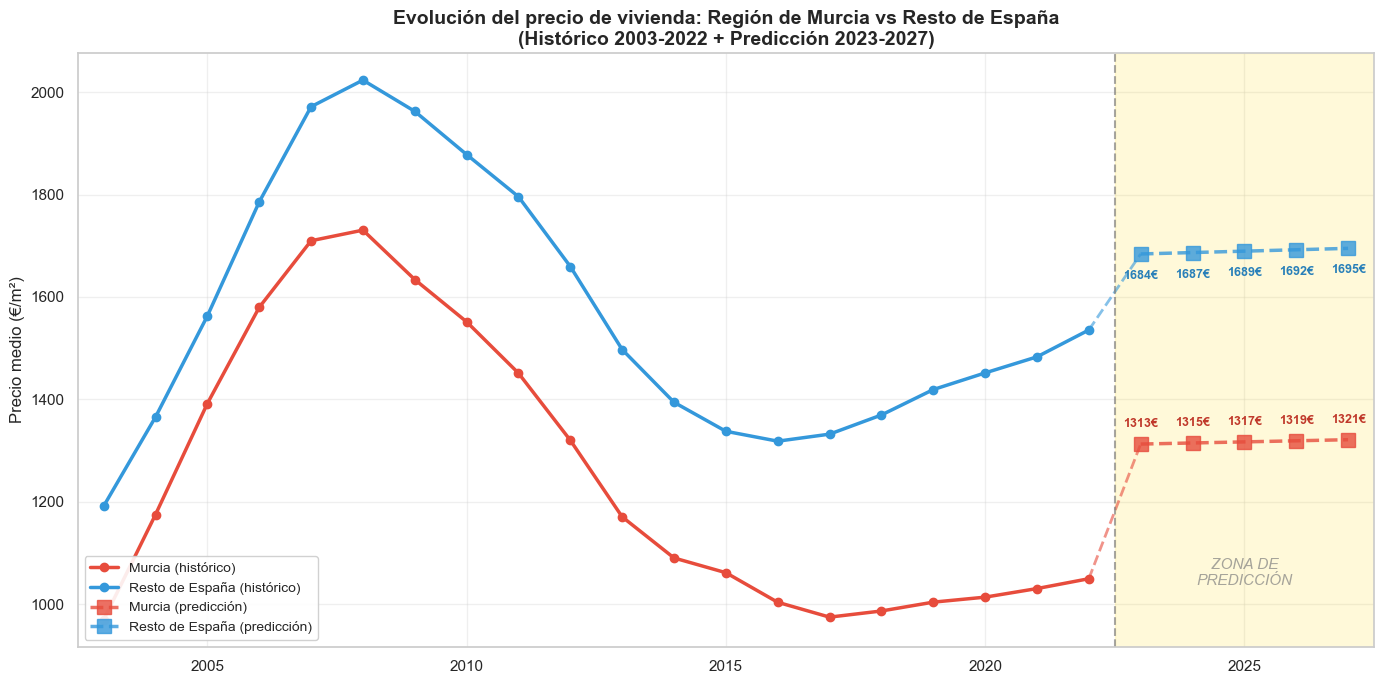

In [50]:

# 3. Crear la visualización
fig, ax = plt.subplots(figsize=(14, 7))

# Datos históricos (línea continua)
ax.plot(df_murcia_hist.index, df_murcia_hist.values, 'o-', color='#E74C3C', linewidth=2.5, 
        markersize=6, label='Murcia (histórico)')
ax.plot(df_resto_hist.index, df_resto_hist.values, 'o-', color='#3498DB', linewidth=2.5, 
        markersize=6, label='Resto de España (histórico)')

# Conectar histórico con predicción (primero para que quede debajo)
ax.plot([ultimo_anio, anios_futuros[0]], [df_murcia_hist.iloc[-1], pred_murcia[0]], 
        '--', color='#E74C3C', alpha=0.6, linewidth=2)
ax.plot([ultimo_anio, anios_futuros[0]], [df_resto_hist.iloc[-1], pred_resto[0]], 
        '--', color='#3498DB', alpha=0.6, linewidth=2)

# Predicciones (línea discontinua con marcadores cuadrados)
ax.plot(anios_futuros, pred_murcia, 's--', color='#E74C3C', linewidth=2.5, 
        markersize=10, alpha=0.8, label='Murcia (predicción)')
ax.plot(anios_futuros, pred_resto, 's--', color='#3498DB', linewidth=2.5, 
        markersize=10, alpha=0.8, label='Resto de España (predicción)')

# Sombrear zona de predicción
ax.axvspan(ultimo_anio + 0.5, anios_futuros[-1] + 0.5, alpha=0.15, color='gold')

# Línea de separación histórico/predicción
ax.axvline(x=ultimo_anio + 0.5, color='gray', linestyle='--', alpha=0.7, linewidth=1.5)

# Añadir anotaciones con valores en los años predichos
for i, anio in enumerate(anios_futuros):
    ax.annotate(f'{pred_murcia[i]:.0f}€', (anio, pred_murcia[i]), 
                textcoords="offset points", xytext=(0, 12), ha='center', fontsize=9, 
                color='#C0392B', fontweight='bold')
    ax.annotate(f'{pred_resto[i]:.0f}€', (anio, pred_resto[i]), 
                textcoords="offset points", xytext=(0, -18), ha='center', fontsize=9, 
                color='#2980B9', fontweight='bold')

# Configuración del gráfico
ax.set_xlabel('', fontsize=12)
ax.set_ylabel('Precio medio (€/m²)', fontsize=12)
ax.set_title('Evolución del precio de vivienda: Región de Murcia vs Resto de España\n(Histórico 2003-2022 + Predicción 2023-2027)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim(df_murcia_hist.index.min() - 0.5, anios_futuros[-1] + 0.5)

# Añadir texto explicativo
ax.text(ultimo_anio + 3, ax.get_ylim()[1] * 0.5, 'ZONA DE\nPREDICCIÓN', 
        fontsize=11, color='gray', ha='center', style='italic', alpha=0.7)

plt.tight_layout()
plt.show()


In [44]:
# 4. Tabla resumen de predicciones
print("\n" + "=" * 80)
print("TABLA RESUMEN DE PREDICCIONES (2023-2027)")
print("=" * 80)
df_pred_tabla = pd.DataFrame({
    'Año': anios_futuros,
    'Murcia (€/m²)': [f'{p:.2f}' for p in pred_murcia],
    'Resto España (€/m²)': [f'{p:.2f}' for p in pred_resto],
    'Diferencia (€/m²)': [f'{r-m:+.2f}' for m, r in zip(pred_murcia, pred_resto)],
    'Murcia vs Resto': [f'{(m/r)*100:.1f}%' for m, r in zip(pred_murcia, pred_resto)]
})
display(df_pred_tabla)

# Resumen final
modelo_usado = resultados[0]['Modelo']
print(f"\nModelo utilizado para predicción: {modelo_usado} (R² = {resultados[0]['R2']:.4f})")
print(f"Nota: Se usa Regresión Lineal para extrapolación porque es más estable que Polinomial")
print(f"\nÚltimo año histórico: {ultimo_anio}")
print(f"Precio Murcia {ultimo_anio}: {df_murcia_hist.iloc[-1]:.2f} €/m²")
print(f"Precio Resto España {ultimo_anio}: {df_resto_hist.iloc[-1]:.2f} €/m²")


TABLA RESUMEN DE PREDICCIONES (2023-2027)


,Año,Murcia (€/m²),Resto España (€/m²),Diferencia (€/m²),Murcia vs Resto
0,2023,1312.85,1683.97,+371.12,78.0%
1,2024,1314.98,1686.70,+371.72,78.0%
2,2025,1317.11,1689.43,+372.32,78.0%
3,2026,1319.24,1692.17,+372.93,78.0%
4,2027,1321.38,1694.91,+373.53,78.0%



Modelo utilizado para predicción: Regresión Lineal Múltiple (R² = 0.9310)
Nota: Se usa Regresión Lineal para extrapolación porque es más estable que Polinomial

Último año histórico: 2022
Precio Murcia 2022: 1050.00 €/m²
Precio Resto España 2022: 1535.53 €/m²
